In [ ]:
#introducing libraries
!pip install numpy scipy pandas>1.0 matplotlib

In [ ]:
#calling up libraries
from datetime import datetime
import pandas as pd
import numpy as np
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [ ]:
#import CSV data from 
URL_Sample = "https://raw.githubusercontent.com/farbowitz/PHY6000/main/c-si%2025degc%20oriel%201000w_m2.csv"
URL_1suns = "https://raw.githubusercontent.com/farbowitz/PHY6011/main/20-11-17_14-26-32%201.0suns%20Current-Voltage%20Data.csv" 
URL_8suns = "https://raw.githubusercontent.com/farbowitz/PHY6011/main/20-11-17_14-40-27%200.8suns%20Current-Voltage%20Data.csv"
URL_IRR = "https://raw.githubusercontent.com/farbowitz/PHY6011/main/1sun%20spectrum.txt"
URL_CALIB = "https://raw.githubusercontent.com/farbowitz/PHY6000/main/FLMS02587_ccda_20180716_1441.IRRADCAL.csv"
AvsVdata = pd.read_csv("https://raw.githubusercontent.com/farbowitz/PHY6011/main/20-11-17_15-25-41%20red-2%20Current-Voltage%20Data.csv", sep = ',' , header = 2)
irr_spec = pd.read_csv(URL_IRR, sep = '\t' , header = 12)    
calib_spec = pd.read_csv(URL_CALIB, sep=',', header = 0)
blue_spec = pd.read_csv("https://raw.githubusercontent.com/farbowitz/PHY6011/main/blue.txt", sep = '\t' , header = 12)

red_spec = pd.read_csv("https://raw.githubusercontent.com/farbowitz/PHY6011/main/red.txt", sep = '\t' , header = 12)
cellarea = 5.02e-6
timems = float(list(pd.read_csv(URL_IRR, sep = ':' , header = 5))[1])/2
#matching WL data
calib_spec['Wavelength(nm)'] = np.round_(calib_spec['Wavelength(nm)'], 3)

In [ ]:
#Merge and compute
spec_data = calib_spec.merge(irr_spec, how = 'left')
spec_data['Spectral Power(W/nm)'] = spec_data[' Counts']*spec_data[' uJoule/count']*1e-6/timems
spec_data['Spectral Irradiance (W/m^2/nm)'] = spec_data['Spectral Power(W/nm)']/(4.0035e-5)
irrad = np.asarray(calib_spec[' uJoule/count'])*np.asarray(irr_spec[' Counts'])*1e-6/timems
rsum = 0
for i in range(2047):
  rsum += (irrad[i]/(4e-5))*(np.asarray(calib_spec['Wavelength(nm)'])[i+1] - np.asarray(calib_spec['Wavelength(nm)'])[i])
  i += 1
rsum

85.51991740037654

In [ ]:
x=[]
for i in range(35):
  x.append(float(np.asarray(AvsVdata['V'][0:35])[i]))
x

[-0.10128,
 -0.081358,
 -0.061262,
 -0.041247,
 -0.021062,
 -0.0010045,
 0.019176,
 0.038844,
 0.058974,
 0.078947,
 0.09903,
 0.11904,
 0.13908,
 0.15914,
 0.17915,
 0.19928,
 0.21899,
 0.23907,
 0.25902,
 0.2792,
 0.29916,
 0.31932,
 0.33928,
 0.35942,
 0.37934,
 0.39907,
 0.41904,
 0.43911,
 0.4591,
 0.47911,
 0.49911,
 0.51905,
 0.53903,
 0.55886,
 0.5785]

('Data',
 129.02634946365194,
 -5.75475879742896,
 0.4845282743700664,
 -2.169515982071713,
 0.7780662960442538,
 3349.505742177166)

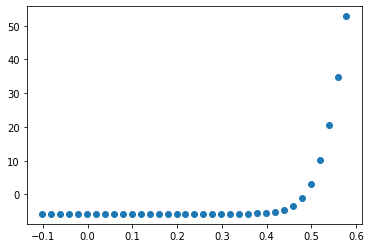

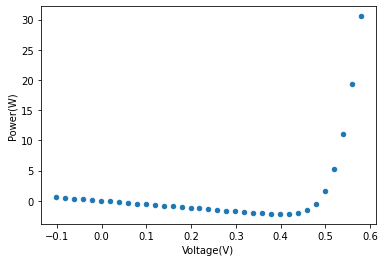

In [ ]:
bigdf = pd.DataFrame(columns = ['Experiment Type','Irradiance', 'Jsc', 'Voc', 'Pmax', 'FF', 'PCE'])
def get_vals(input_data, spectrum):
  x=[]
  y=[]
  for i in range(35):
    #converts into 1D array by column number
    x.append(float(np.asarray(input_data[list(input_data)[0]][0:35])[i]))
    #changing mA/cm^2 to A/m^2
    y.append(10*float(np.asarray(input_data[list(input_data)[1]][0:35])[i]))
  plt.scatter(x, y)
  #creates spline cubic interpolation function
  f = interp1d(x, y, 'cubic')
  #get zeroes from interpolation 
  Jsc = float(f(0))
  Voc = float(scipy.interpolate.InterpolatedUnivariateSpline(x, y).roots())
  #plot x*y vs x to get P vs V
  PvsVdata = pd.DataFrame(np.stack((np.asarray(x), np.asarray(x)*np.asarray(y)), axis =-1), columns=('Voltage(V)', 'Power(W)'))
  PvsVdata.plot.scatter(x=0, y=1)
  #other relevant quantities
  Pmax = min(PvsVdata['Power(W)'])
  FF = Pmax /(Jsc*Voc)
  #Irradiance from spectral data
  Ispec = (np.asarray(calib_spec[' uJoule/count'])*np.asarray(spectrum[list(spectrum)[0]])).sum()*1e-6/(timems*4.00393e-5)
  PCE = -Pmax / (Ispec*cellarea)
  return 'Data', Ispec, Jsc, Voc, Pmax, FF , PCE
get_vals(AvsVdata, red_spec)

KeyError: ignored

In [ ]:
def interpolate_cal(input_spectrum):
  #converts into 1D array by column number
  x = np.asarray(input_spectrum[list(input_spectrum)[0]])
  y = np.asarray(input_spectrum[list(input_spectrum)[1]])
  #creates spline cubic interpolation function
  f = interp1d(x, y, 'cubic')
  #creates new integer-valued wls 
  int_x = np.linspace(int(np.floor(np.min(x))+1), int(np.floor(np.max(x))), int(np.floor(np.max(x))-np.floor(np.min(x))))
  #apply interpolation
  int_y = f(int_x)
  df = pd.DataFrame(np.stack((int_x, int_y), axis =-1))
  return df
#build 
irr_int = interpolate_cal(irr_spec)
irr_int.columns = ['Wavelength(nm)', 'Counts']
cal_int = interpolate_cal(calib_spec)
cal_int.columns = ['Wavelength(nm)', 'uJoule/count']
spec_data = irr_int.merge(cal_int, how='left')
spec_data

,Wavelength(nm),Counts,uJoule/count
0,340.0,-50.730000,-1.292470e-26
1,341.0,-73.757627,2.488809e-09
2,342.0,-36.996443,-6.477047e-08
3,343.0,-77.979299,-1.022639e-06
4,344.0,-46.290978,8.783241e-05
...,...,...,...
677,1017.0,511.338466,4.476179e-03
678,1018.0,485.269099,4.630291e-03
679,1019.0,579.335788,4.737873e-03
680,1020.0,528.776415,4.762076e-03


In [ ]:
#constructing other values
spec_data['Spectral Power (W/nm)'] = spec_data['Counts']*spec_data['uJoule/count']*1e-6/timems
spec_data['Spectral Irradiance (W/m^2/nm)'] = spec_data['Spectral Power (W/nm)']/(4.00393e-5)
spec_data

,Wavelength(nm),Counts,uJoule/count,Spectral Power (W/nm),Spectral Irradiance (W/m^2/nm)
0,340.0,-50.730000,-1.292470e-26,6.556699e-30,1.637566e-25
1,341.0,-73.757627,2.488809e-09,-1.835687e-12,-4.584712e-08
2,342.0,-36.996443,-6.477047e-08,2.396277e-11,5.984813e-07
3,343.0,-77.979299,-1.022639e-06,7.974464e-10,1.991659e-05
4,344.0,-46.290978,8.783241e-05,-4.065848e-08,-1.015464e-03
...,...,...,...,...,...
677,1017.0,511.338466,4.476179e-03,2.288842e-05,5.716490e-01
678,1018.0,485.269099,4.630291e-03,2.246937e-05,5.611830e-01
679,1019.0,579.335788,4.737873e-03,2.744820e-05,6.855314e-01
680,1020.0,528.776415,4.762076e-03,2.518074e-05,6.289005e-01


In [ ]:
#Reimann sum - low whether I use WL interval or 1.

rsum = 0
for i in range(682):
  rsum += spec_data['Spectral Irradiance (W/m^2/nm)'][i]
  i += 1
rsum
 

85.44038785323636